In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tensorflow import keras
from tqdm.notebook import tqdm
from sklearn.model_selection import GroupShuffleSplit 

import glob
import sys
import math
import gc
import sys
import sklearn
import scipy
import json

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

Tensorflow V2.10.0
Keras V2.10.0
Python V3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [2]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3, 0))

print("GPU Available:", gpu_available)
print("CUDA GPU Available:", is_cuda_gpu_available)
print("CUDA GPU with Minimum Compute Capability 3.0 Available:", is_cuda_gpu_min_3)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
CUDA GPU Available: True
CUDA GPU with Minimum Compute Capability 3.0 Available: True


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Training Model Config


In [4]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250

INPUT_SIZE = 12
BATCH_ALL_SIGNS_N = 1
BATCH_SIZE = 256
N_EPOCHS = 120
LR_MAX = 0.001
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

N_MODELS = 4 

In [5]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Data Understanding

In [6]:
data_train = pd.read_csv('D:/NEW/dataset/train_new_1.csv')

In [7]:
data_train['sign'].value_counts()

sign
listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: count, Length: 250, dtype: int64

In [8]:
N_SAMPLES = len(data_train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


##### Add File Path

In [9]:
# Get complete file path to file
def get_file_path(path):
    return f'D:/NEW/dataset/{path}'

data_train['file_path'] = data_train['path'].apply(get_file_path)

##### Ordinally Encode Sign

In [10]:
# Add ordinally Encoded Sign (assign number to each sign name)
data_train['sign_ord'] = data_train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = data_train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = data_train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [11]:
len(data_train['sign'].unique())

250

In [12]:
display(data_train.sort_values(by='sign_ord'))
display(data_train.tail())
data_train['sign_ord'].value_counts().sort_index()

,path,participant_id,sequence_id,sign,video_path,skeleton_path,file_path,sign_ord
67163,train_landmark_files/18796/3751667683.parquet,18796,3751667683,TV,NaN,NaN,D:/NEW/dataset/train_landmark_files/18796/3751...,0
90602,train_landmark_files/32319/838882027.parquet,32319,838882027,TV,NaN,NaN,D:/NEW/dataset/train_landmark_files/32319/8388...,0
30349,train_landmark_files/34503/2246961789.parquet,34503,2246961789,TV,NaN,NaN,D:/NEW/dataset/train_landmark_files/34503/2246...,0
2874,train_landmark_files/62590/1118807928.parquet,62590,1118807928,TV,NaN,NaN,D:/NEW/dataset/train_landmark_files/62590/1118...,0
90555,train_landmark_files/61333/836954816.parquet,61333,836954816,TV,NaN,NaN,D:/NEW/dataset/train_landmark_files/61333/8369...,0
...,...,...,...,...,...,...,...,...
35616,train_landmark_files/62590/2457549279.parquet,62590,2457549279,zipper,NaN,NaN,D:/NEW/dataset/train_landmark_files/62590/2457...,249
59264,train_landmark_files/16069/3426738975.parquet,16069,3426738975,zipper,NaN,NaN,D:/NEW/dataset/train_landmark_files/16069/3426...,249
75344,train_landmark_files/36257/4085941753.parquet,36257,4085941753,zipper,NaN,NaN,D:/NEW/dataset/train_landmark_files/36257/4085...,249
46209,train_landmark_files/4718/2887082060.parquet,4718,2887082060,zipper,NaN,NaN,D:/NEW/dataset/train_landmark_files/4718/28870...,249


,path,participant_id,sequence_id,sign,video_path,skeleton_path,file_path,sign_ord
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,NaN,NaN,D:/NEW/dataset/train_landmark_files/53618/9997...,238
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,NaN,NaN,D:/NEW/dataset/train_landmark_files/26734/9997...,108
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,NaN,NaN,D:/NEW/dataset/train_landmark_files/25571/9998...,86
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,NaN,NaN,D:/NEW/dataset/train_landmark_files/29302/9998...,188
94476,train_landmark_files/36257/999962374.parquet,36257,999962374,happy,NaN,NaN,D:/NEW/dataset/train_landmark_files/36257/9999...,105


sign_ord
0      385
1      347
2      393
3      386
4      390
      ... 
245    398
246    385
247    379
248    375
249    299
Name: count, Length: 250, dtype: int64

# Data Understanding# Landmark Indices

In [13]:
# Define three data types: left hand, pose, and right hand
USE_TYPES = ['left_hand', 'pose', 'right_hand']

# Define starting index in original da
START_IDX = 468

# Define lip landmark indexes in original data, a total of 40
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

print('Lip: ', LIPS_IDXS0)

############################################################# Hand ############################################################
# Landmark indices in original data
# Define left hand landmark indexes in original data, a total of 21
LEFT_HAND_IDXS0 = np.arange(468,489)
# Define right hand landmark indexes in original data, a total of 21
RIGHT_HAND_IDXS0 = np.arange(522,543)

print('Left Hand: ', LEFT_HAND_IDXS0)
print('Right Hand: ', RIGHT_HAND_IDXS0)

############################################################# Pose ############################################################
# Define left pose landmark indexes in original data, a total of 5
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
# Define right pose landmark indexes in original data, a total of 5
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

print('Left Pose: ', LEFT_POSE_IDXS0)
print('Right Pose: ', RIGHT_POSE_IDXS0) 

# Define landmark indexes for left-hand-dominant data, including lips, left hand, and left pose, a total of 66
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
# Define landmark indexes for Right-hand-dominant data, including lips, Right hand, and Right pose, a total of 66
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
# Define Hand landmark indexes, including Left Hand and Right Hand, a total of 42
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
# Define number of columns in processed data, which is 66
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size

print('\n')
print('LEFT DOMINANT: ', LANDMARK_IDXS_LEFT_DOMINANT0)
print('Right DOMINANT: ', LANDMARK_IDXS_RIGHT_DOMINANT0)
print('Both Hand: ', HAND_IDXS0)

# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print('\n')
print('lips: ', LIPS_IDXS)
print('left hand: ', LEFT_HAND_IDXS)
print('right hand: ', RIGHT_HAND_IDXS)
print('both hand: ', HAND_IDXS)
print('pose: ', POSE_IDXS)

print('\n')
print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

Lip:  [ 61 185  40  39  37   0 267 269 270 409 291 146  91 181  84  17 314 405
 321 375  78 191  80  81  82  13 312 311 310 415  95  88 178  87  14 317
 402 318 324 308]
Left Hand:  [468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488]
Right Hand:  [522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542]
Left Pose:  [502 504 506 508 510]
Right Pose:  [503 505 507 509 511]


LEFT DOMINANT:  [ 61 185  40  39  37   0 267 269 270 409 291 146  91 181  84  17 314 405
 321 375  78 191  80  81  82  13 312 311 310 415  95  88 178  87  14 317
 402 318 324 308 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 502 504 506 508 510]
Right DOMINANT:  [ 61 185  40  39  37   0 267 269 270 409 291 146  91 181  84  17 314 405
 321 375  78 191  80  81  82  13 312 311 310 415  95  88 178  87  14 317
 402 318 324 308 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538 539 540 541 542 503 505 50

In [14]:
# Define the starting position for lip keypoints, set to 0
LIPS_START = 0

# Define the starting position for left hand keypoints, which is the number of lip keypoints
LEFT_HAND_START = LIPS_IDXS.size

# Define the starting position for right hand keypoints, which is the starting position of left hand keypoints plus the number of left hand keypoints
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size

# Define the starting position for pose keypoints, which is the starting position of right hand keypoints plus the number of right hand keypoints
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

# Print the starting positions for different parts of keypoints
print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Data Pre-processing

In [15]:
# number of landmarks per frame
# Face = 468, Pose = 33, Hand = 21 each
ROWS_PER_FRAME = 543 
#`load_relevant_data_subset
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    # get no of frame
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

### Process Data Using Tensorflow
*PreprocessLayer is TensorFlow layer designed to process data in TFLite. The purpose of this layer is to process the input data in a specific way that is required by the model. The processing steps involve filtering frames that contain data related to the dominant hand, normalizing the coordinates of the dominant hand, padding the data to a specific size, and filling NaN values with zeros.*

In [16]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
 
    # data0
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        
        # Enable eager execution
        tf.config.run_functions_eagerly(True)

        # TRUNCATE LONG VIDEOS
        N_FRAMES0 = tf.shape(data0)[0]
        data0 = tf.slice(data0, [0,0,0], [tf.math.minimum(INPUT_SIZE * INPUT_SIZE,N_FRAMES0),-1,-1])
        
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        # tf.gather is gather the value according to the indices
        # tf.where is returns the indices of non-zero elements
        # tf.math.reduce_sum is to computes the sum of elements across dimensions of a tensor.
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        # determine which hand has dominant
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
            # print('Left Dominant')
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
            # print('Right Dominant')
        
        # Find frames indices with coordinates of dominant hand - return in indeces
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames - get only the non empty frame
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)

        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        # LANDMARK_IDXS_LEFT_DOMINANT0 = Define landmark indexes for left-hand-dominant data, including lips, left hand, and left pose, a total of 66
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (self.normalisation_correction + 
                    (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0)
                    )
                   )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat < 4096
            if N_FRAMES < INPUT_SIZE**2:
                # repeat the frame [28] times 
                # ori got 85 frame --> 2380 frame
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)

            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

## Interpolate NaN Values

In [17]:
def get_data(file_path):
    # Load Raw Data
    # return x, y, z in 3D array
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    # return processed data using Tensorflow
    data = preprocess_layer(data)
    
    return data

## Create Dataset
*included train and test split

In [18]:
# Get the full dataset
def preprocess_data(dir, data_train):
    root_dir = dir
    # Create arrays to save data (initialization)
    # The numpy.zeros() function returns a new array of given shape and type, with zeros
    # each value in the numpy array would be a float of size 32 bits - 4D array
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    # Creat 2D array and return a new array with fill_value
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    # sign_ord = integer code for each unique sign
    ctr_error = 0
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(data_train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')
        try:
            data, non_empty_frame_idxs = get_data(file_path)
        except:
            print(ctr_error)
            ctr_error+=1
            continue
            
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save(f'{root_dir}/X.npy', X)
    np.save(f'{root_dir}/y.npy', y)
    np.save(f'{root_dir}/NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # Save Validation
    # purpose of using GroupShuffleSplit is to ensure that it take individual group for training
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    print('splitter: ', splitter)
    # group by the participant id
    PARTICIPANT_IDS = data_train['participant_id'].values
    print('PARTICIPANT_IDS: ', PARTICIPANT_IDS)
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))
    print(train_idxs, val_idxs)
    print('train_idxs: ', train_idxs)
    print('val_idxs: ', val_idxs)
    
    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save(f'{root_dir}/X_train.npy', X_train)
    np.save(f'{root_dir}/y_train.npy', y_train)
    np.save(f'{root_dir}/NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save(f'{root_dir}/X_val.npy', X_val)
    np.save(f'{root_dir}/y_val.npy', y_val)
    np.save(f'{root_dir}/NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [20]:
def data_processing(data_path):  
    # Preprocess All Data From Scratch
    PREPROCESS_DATA = False
    if PREPROCESS_DATA:
        ROOT_DIR = data_path
        preprocess_data(ROOT_DIR)
    else:
        ROOT_DIR = data_path
        
    # Load Data
    if USE_VAL:
        # Load Train
        X_train = np.load(f'{ROOT_DIR}/X_train.npy')
        y_train = np.load(f'{ROOT_DIR}/y_train.npy')
        NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
        # Load Val
        X_val = np.load(f'{ROOT_DIR}/X_val.npy')
        y_val = np.load(f'{ROOT_DIR}/y_val.npy')
        NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
        # Define validation Data
        validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)

        # Train 
        print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
        print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
        # Sanity Check
        print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

        return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL, validation_data

    else:
        X_train = np.load(f'{ROOT_DIR}/X.npy')
        y_train = np.load(f'{ROOT_DIR}/y.npy')
        NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
        validation_data = None

        # Train 
        print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
        # Sanity Check
        print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

        return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, validation_data

In [21]:
if USE_VAL:
    X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL, validation_data = data_processing(r'D:\NEW\FYP\data\new')
else:
    X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, validation_data = data_processing(r'D:\NEW\FYP\data\new')

X_train shape: (80229, 12, 66, 3), dtype: float32
y_train shape: (80229,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (80229, 12), dtype: float32
X_val shape: (14248, 12, 66, 3), dtype: float32
y_val shape: (14248,), dtype: int32
NON_EMPTY_FRAME_IDXS_VAL shape: (14248, 12), dtype: float32
# NaN Values X_train: 0


In [22]:
display(len(pd.Series(y_train).unique()))

250

In [23]:
pd.Series(y_train).unique()

array([ 25, 232,  48,  23, 164,  67, 143, 134,  86, 220, 231,   8, 180,
       144, 216,  65, 195, 165, 243, 156, 249,  45, 181, 108,  49,  41,
       207, 196, 235, 193,  70,  74,  14,  89, 190, 121, 162,  97,  62,
         0,   6,  93, 233,  19,  13,  35, 191,  34,  81, 159,  12, 198,
       136, 215,  24, 161,   4,  47, 146,  78, 172, 194,  76, 125, 192,
       157, 127, 199, 210,  83,  30, 101, 228,  84,  51, 203,  66, 102,
        32, 150,  77, 189, 169,  92, 152, 104, 239,  31,  54,  63, 205,
        85, 223,  11, 214, 120, 132, 237, 115, 176,  61, 153, 110,  87,
       147, 178, 158,  73,   5,  21, 154, 236, 105, 209, 206, 238,  33,
       117,  79,  27,   3, 219, 168, 200,  99,  44, 109, 182,  75,   7,
       248, 183, 226,  52,  60,  17, 133, 246,  64, 141,  15,  10, 241,
       107, 177, 129,  82,  20,  59, 234, 204, 128, 137, 114, 135,  95,
       242,  55, 103, 111, 186, 163,  53, 229, 160, 173,  42, 201, 167,
       245, 119, 171, 211,  72, 208, 174,   9, 212, 100, 222, 17

# Compute Landmark Means and STDs
### Feature Statistics - Lips

  0%|          | 0/40 [00:00<?, ?it/s]

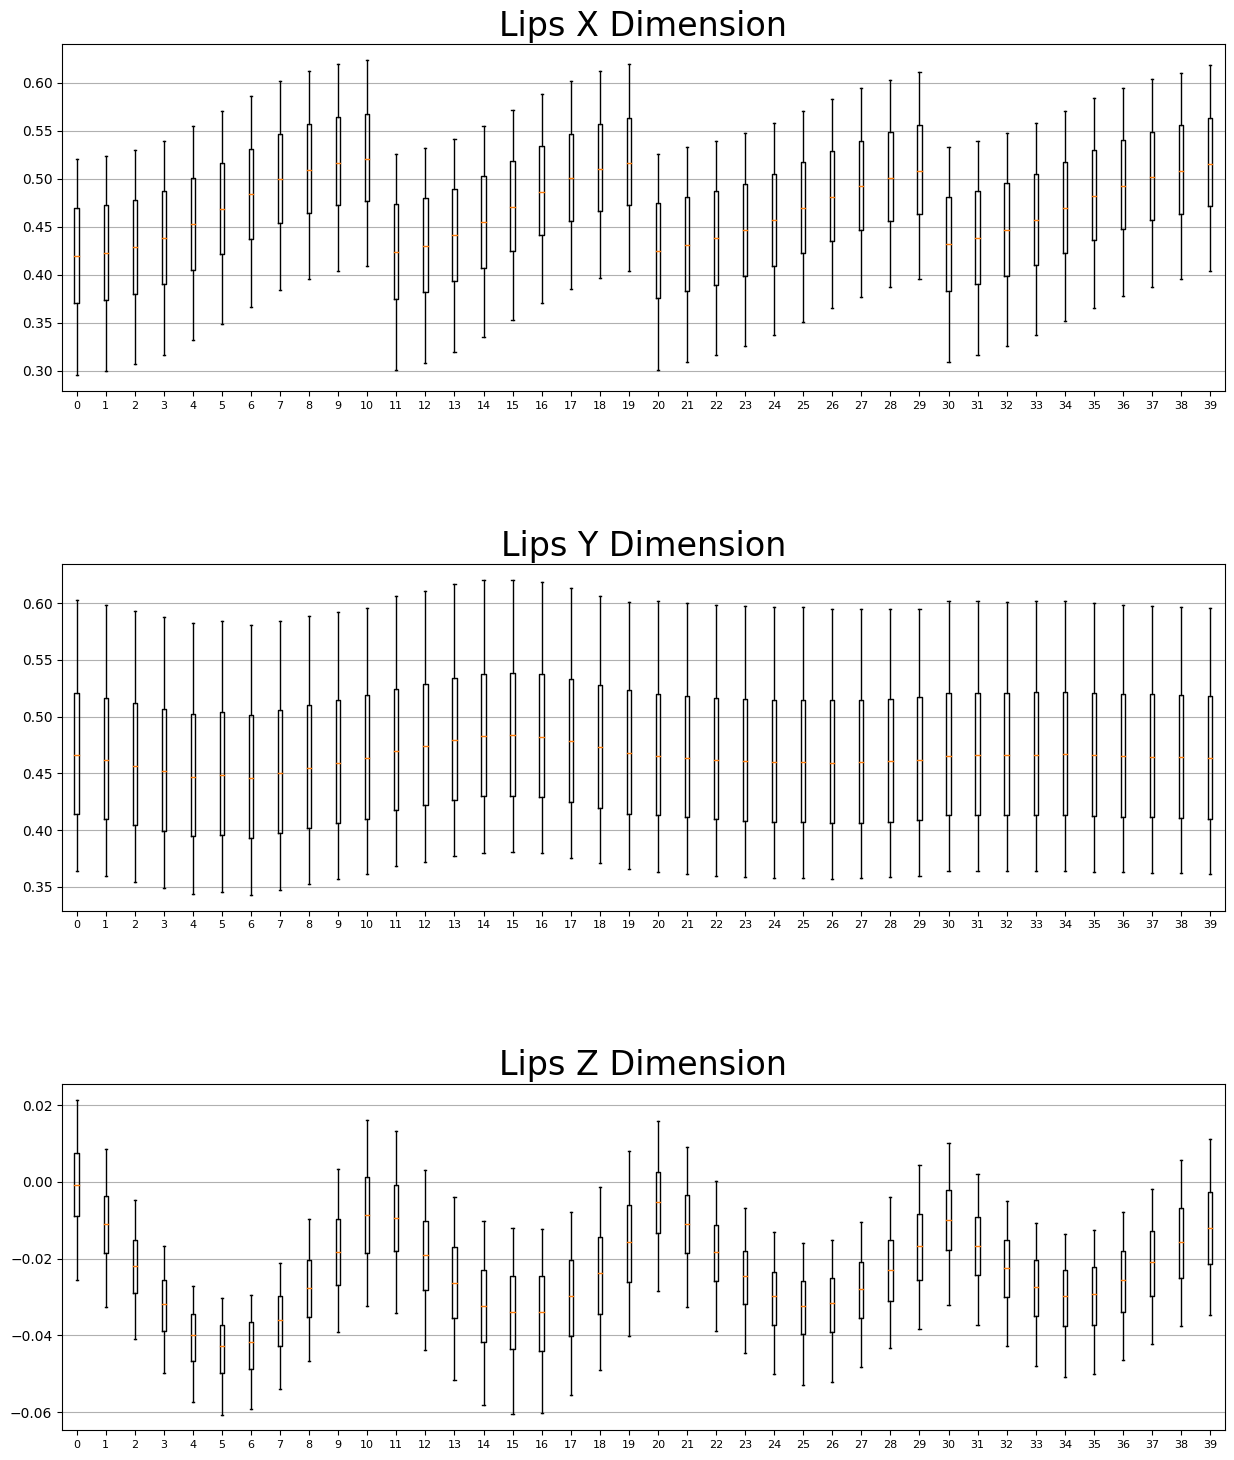

In [24]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

### Feature Statistics - Hands


  0%|          | 0/21 [00:00<?, ?it/s]

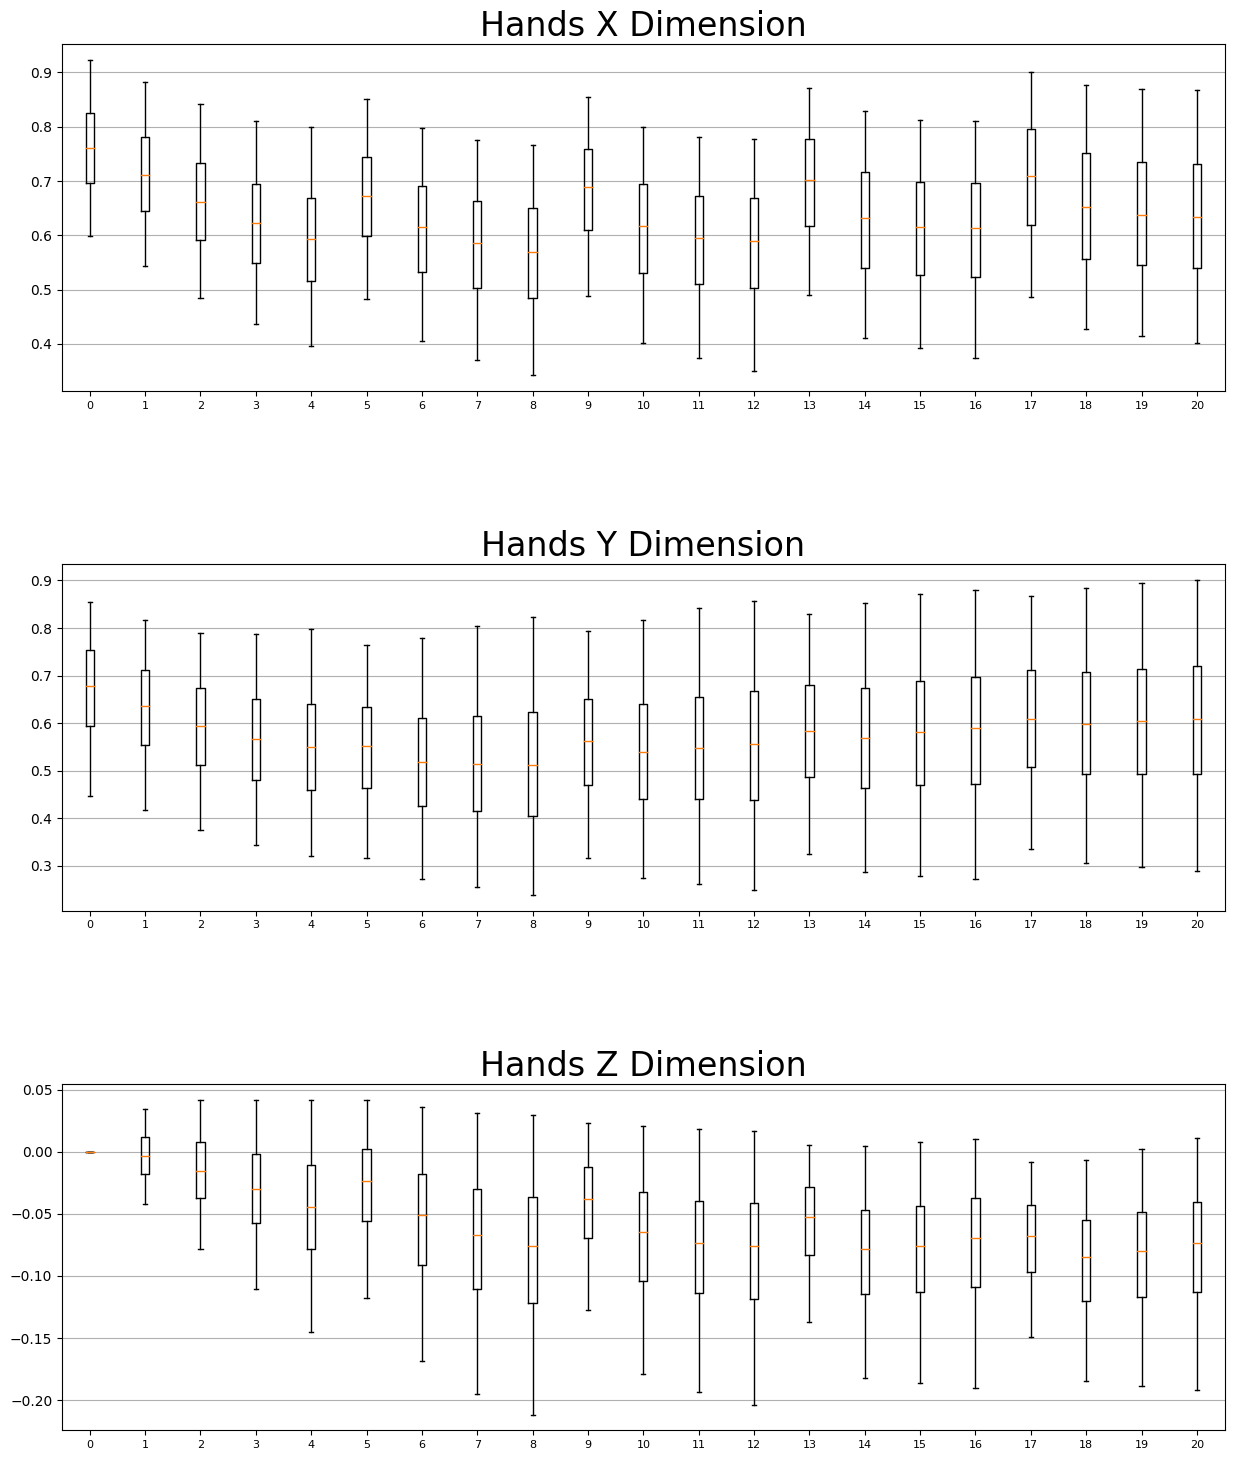

In [25]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

### Feature Statistics - Pose


  0%|          | 0/5 [00:00<?, ?it/s]

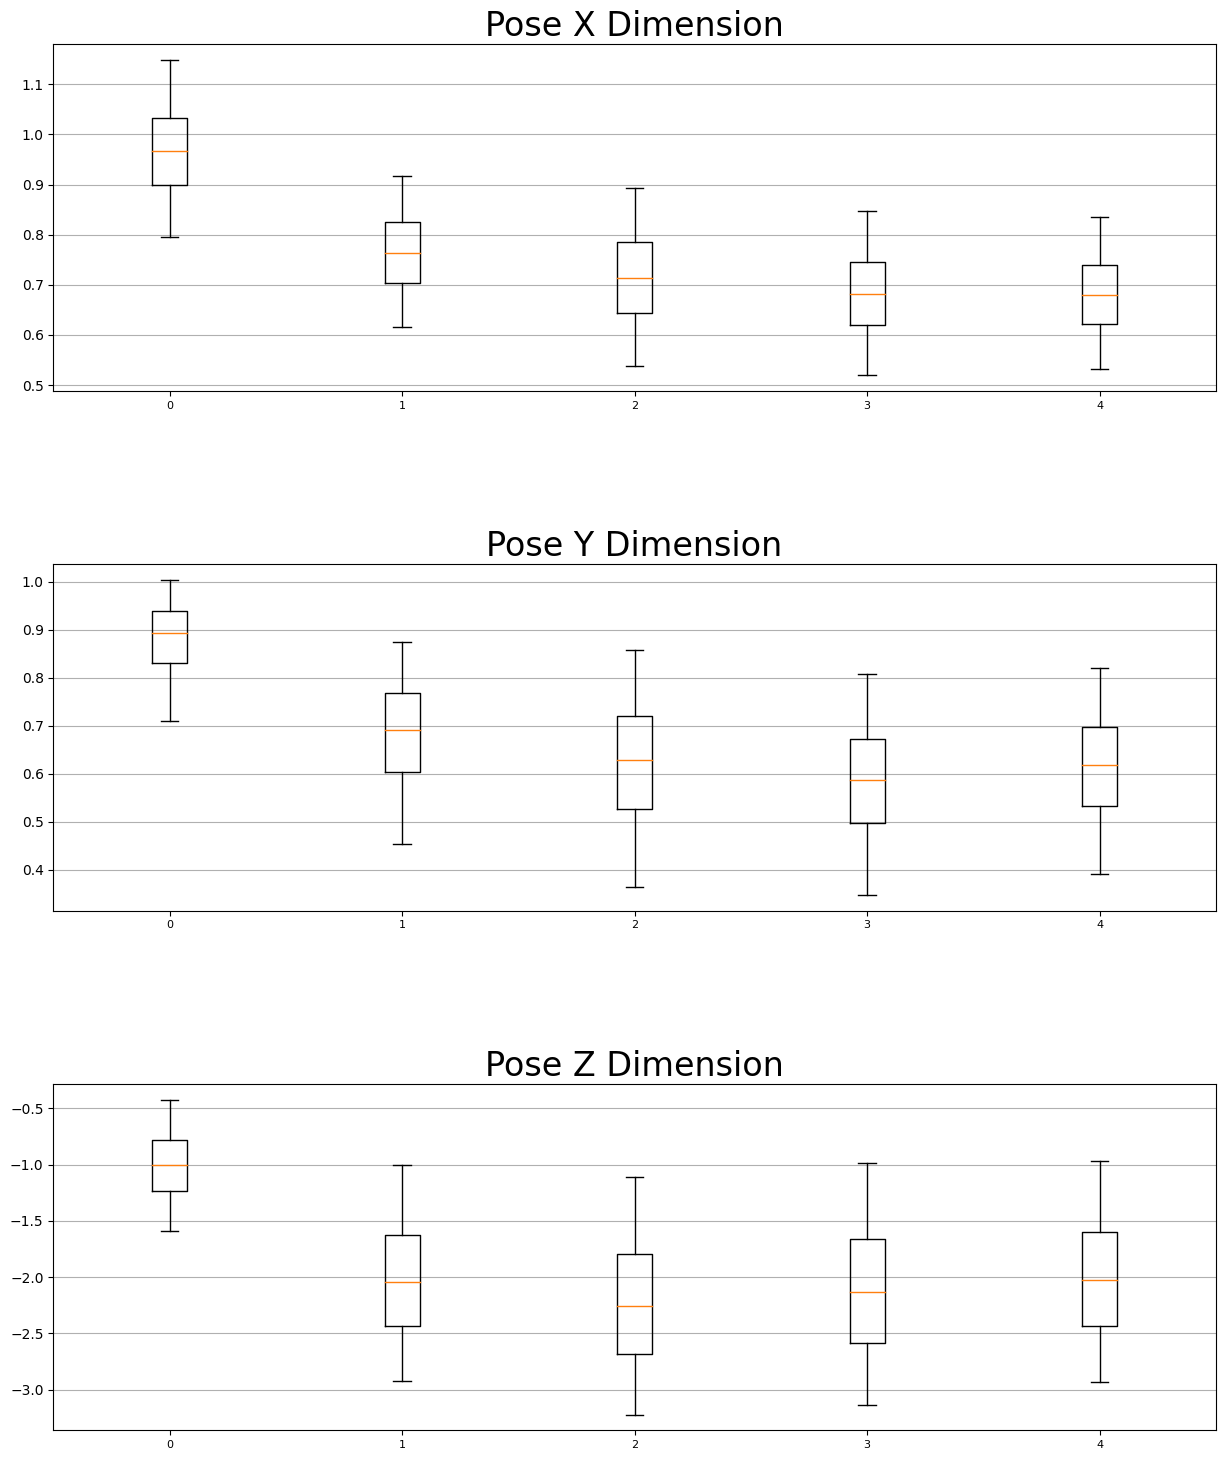

In [26]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Data Loader with Augmentation

In [27]:
TIME_AUG_PROB = 0.25
FRAME_DROP_PROB = 0.0

# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            tmp = X[idxs].copy()
            tmp2 = NON_EMPTY_FRAME_IDXS[idxs].copy()
            
            # FRAME DROP AUGMENTATION
            if np.random.uniform(0,1)<FRAME_DROP_PROB:
                j = np.random.randint(0,INPUT_SIZE)
                tmp[0,j,:,:] = 0
            
            # TIME SCALE AUGMENTATION
            if np.random.uniform(0,1)<TIME_AUG_PROB:
                ct = ( NON_EMPTY_FRAME_IDXS[idxs[0]] != -1 ).sum()
                if (ct==12):
                    mask = np.random.choice([True, False],12)
                    mask[0] = True
                    mask[-1] = True
                    c = mask.sum()
                    tmp[0,:c,:,:] = tmp[0,mask,:,:]
                    tmp[0,c:,:,:] = 0
                    tmp2[0,:c] = tmp2[0,mask]
                    tmp2[0,c:] = -1
                elif ct>6:
                    tmp[0,:6,:,:] = tmp[0,::2,:,:]
                    tmp[0,6:,:,:] = 0
                    tmp2[0,:6] = tmp2[0,::2]
                    tmp2[0,6:] = -1
                elif (ct<=2)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,1::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,2::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,3::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,4::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,5::6,:,:] = tmp[0,:2,:,:]
                    tmp2[0,::6] = tmp2[0,:2]
                    tmp2[0,1::6] = tmp2[0,:2]
                    tmp2[0,2::6] = tmp2[0,:2]
                    tmp2[0,3::6] = tmp2[0,:2]
                    tmp2[0,4::6] = tmp2[0,:2]
                    tmp2[0,5::6] = tmp2[0,:2]
                elif (ct<=3)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,1::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,2::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,3::4,:,:] = tmp[0,:3,:,:]
                    tmp2[0,::4] = tmp2[0,:3]
                    tmp2[0,1::4] = tmp2[0,:3]
                    tmp2[0,2::4] = tmp2[0,:3]
                    tmp2[0,3::4] = tmp2[0,:3]
                elif (ct<=4)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::3,:,:] = tmp[0,:4,:,:]
                    tmp[0,1::3,:,:] = tmp[0,:4,:,:]
                    tmp[0,2::3,:,:] = tmp[0,:4,:,:]
                    tmp2[0,::3] = tmp2[0,:4]
                    tmp2[0,1::3] = tmp2[0,:4]
                    tmp2[0,2::3] = tmp2[0,:4]
                else:
                    tmp[0,::2,:,:] = tmp[0,:6,:,:]
                    tmp[0,1::2,:,:] = tmp[0,:6,:,:]
                    tmp2[0,::2] = tmp2[0,:6]
                    tmp2[0,1::2] = tmp2[0,:6]
            
            X_batch[i*n:(i+1)*n] = tmp
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = tmp2
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

# Model Config

In [28]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 224 
HANDS_UNITS = 224
POSE_UNITS = 224
# final embedding and transformer embedding size
UNITS = 376

# Transformer
NUM_BLOCKS = 3
MLP_RATIO = 3

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 376


# Transformer


In [29]:
# MultiHeadAttention is use to focus the  important words / feature in a given frame
#query, key, value represent each single linear in MultilHeadAttention
#consineSimilarity is used to calculate the similarity between query and key (two vector)
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True) # attention filter - remove unnecessary information
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads # default 8 number of head used in this case
        self.depth = d_model//num_of_heads
        # 3 linear of the components in MultiHeadAttention 
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        # last linear layer to shrink the size of vector 
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            # multiple the word embedding with 3 linear
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
        
        # concat multiple attention head where each attention head focusing on differen phenomenon
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [30]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding


In [31]:
# convert to vector
# The attention layers used throughout the model see their input as a set of vectors, with no order.
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding


In [32]:
# Embedding is the vector representation of a given word 
# Embedding layer take input indices and converts it into word embedding and passed it to next layer 
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layersx
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Sparse Categorical Crossentropy With Label Smoothing

In [33]:
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [34]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask0, axis=2)

    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    #optimizer = tfa.optimizers.SGDW(
    #learning_rate=lr, weight_decay=wd, momentum=0.9)
    #optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, nesterov=False) 
    #optimizer = tfa.optimizers.SGDW(learning_rate=0.001, momentum=0.7, weight_decay=0.005)
    #Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [35]:
tf.keras.backend.clear_session()

model = get_model()

In [36]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 12, 66, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 12, 66, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 12, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 12, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

# Learning Rate Scheduler

In [37]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
    
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [38]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [44]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Unique Signs in Validation Set: 250


,Count
38,67
235,66
172,66
106,43
170,35
249,32


# Train

In [39]:
if TRAIN_MODEL:
    models = []
    
    for k in range(N_MODELS):
        print('#'*25)
        print('### Training Model',k,'...')
        print('#'*25)
        
        # Clear all models in GPU
        VERBOSE = 0; VERBOSE2 = 0
        if k==0: 
            tf.keras.backend.clear_session()
            VERBOSE = 2; VERBOSE2 = 1

        # Get new fresh model
        model = get_model()

        # Sanity Check
        #model.summary()

        # Actual Training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], 
                                                               verbose=VERBOSE2)
        history = model.fit(
                x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
                steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
                epochs=N_EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=validation_data,
                callbacks=[
                    lr_callback,
                    WeightDecayCallback(),
                ],
                verbose = VERBOSE,
            )
        
        # Save Model Weights
        model.save_weights(f'model{k}.h5')
        models.append(model)

#########################
### Training Model 0 ...
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/120
320/320 - 40s - loss: 4.0896 - acc: 0.3314 - top_3_acc: 0.5287 - top_5_acc: 0.6108 - top_10_acc: 0.7098 - val_loss: 3.3722 - val_acc: 0.5256 - val_top_3_acc: 0.7456 - val_top_5_acc: 0.8247 - val_top_10_acc: 0.8975 - lr: 0.0010 - 40s/epoch - 124ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009998286624877785.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/120
320/320 - 20s - loss: 3.3030 - acc: 0.5688 - top_3_acc: 0.7641 - top_5_acc: 0.8242 - top_10_acc: 0.8813 - val_loss: 3.1006 - val_acc: 0.6178 - val_top_3_acc: 0.8149 - val_top_5_acc: 0.8730 - val_top_10_acc: 0.9274 - lr: 9.9983e-04 - 20s/epoch - 61ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009993147673772868.
learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 3/120
320/320 - 20

## Validate 4 Models

In [42]:
if USE_VAL:
    preds = []
    for k in range(len(models)):
        # Validation Predictions
        y_val_pred = models[k].predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2)
        preds.append(y_val_pred)
    y_val_pred = np.mean(preds,axis=0).argmax(axis=1)
    acc = (y_val_pred == y_val).mean()
    print('Holdout Validation Ensemble ACC =',acc)

446/446 - 7s - 7s/epoch - 16ms/step
446/446 - 7s - 7s/epoch - 16ms/step
446/446 - 7s - 7s/epoch - 16ms/step
446/446 - 7s - 7s/epoch - 16ms/step
Holdout Validation Ensemble ACC = 0.7881807973048849


In [41]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [43]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
!zip submission.zip /kaggle/working/model.tflite

Left Dominant
Right Dominant
Left Dominant
Right Dominant
Left Dominant
Right Dominant
Left Dominant
Right Dominant
Left Dominant
Right Dominant
  adding: kaggle/working/model.tflite (deflated 8%)


In [19]:
# Custom sampler to get a batch containing N times all signs for validation
def get_validation_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros(
        [NUM_CLASSES * n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n,
                        dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros(
        [NUM_CLASSES * n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i * n:(i + 1) * n] = X[idxs]
            non_empty_frame_idxs_batch[i * n:(i + 1) * n] = NON_EMPTY_FRAME_IDXS[idxs]

        yield {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}, y_batch

In [44]:
# Assuming you have validation data (X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL)
# Evaluate the model on the validation data
if USE_VAL:
    evaluation_results = model.evaluate(
        x=get_validation_batch_all_signs(X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL),
        steps=len(X_val) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        batch_size=BATCH_SIZE,
        verbose=2
    )

    # Print the evaluation results
    print("Validation Loss:", evaluation_results[0])
    print("Validation Sparse Categorical Accuracy:", evaluation_results[1])
    print("Validation Top-5 Accuracy:", evaluation_results[2])
    print("Validation Top-10 Accuracy:", evaluation_results[3])

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


56/56 - 11s - loss: 2.7806 - acc: 0.7682 - top_3_acc: 0.8909 - top_5_acc: 0.9179 - top_10_acc: 0.9406 - 11s/epoch - 195ms/step
Validation Loss: 2.780643939971924
Validation Sparse Categorical Accuracy: 0.7682142853736877
Validation Top-5 Accuracy: 0.8909285664558411
Validation Top-10 Accuracy: 0.9178571701049805


In [45]:
# Assuming you have validation data (X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL)
# Evaluate the model on the validation data
if USE_VAL:
    evaluation_results = model.evaluate(
        x=get_validation_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps=len(X_val) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        batch_size=BATCH_SIZE,
        verbose=2
    )

    # Print the evaluation results
    print("Validation Loss:", evaluation_results[0])
    print("Validation Sparse Categorical Accuracy:", evaluation_results[1])
    print("Validation Top-5 Accuracy:", evaluation_results[2])
    print("Validation Top-10 Accuracy:", evaluation_results[3])

56/56 - 11s - loss: 1.9707 - acc: 1.0000 - top_3_acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - 11s/epoch - 193ms/step
Validation Loss: 1.9706947803497314
Validation Sparse Categorical Accuracy: 1.0
Validation Top-5 Accuracy: 1.0
Validation Top-10 Accuracy: 1.0


In [60]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


446/446 - 69s - 69s/epoch - 154ms/step


# Classification Report

In [62]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [64]:
if USE_VAL:
    print_classification_report()

,precision,recall,f1-score,support
doll,1.00,0.97,0.98,61
owl,0.97,0.98,0.97,57
gum,0.97,0.98,0.97,59
mouse,0.95,0.98,0.97,60
dad,0.95,0.98,0.97,57
frog,0.98,0.96,0.97,54
head,0.97,0.97,0.97,58
grandpa,0.94,0.98,0.96,60
stuck,0.95,0.96,0.96,56
brown,0.93,0.98,0.96,58


# Training History

In [50]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

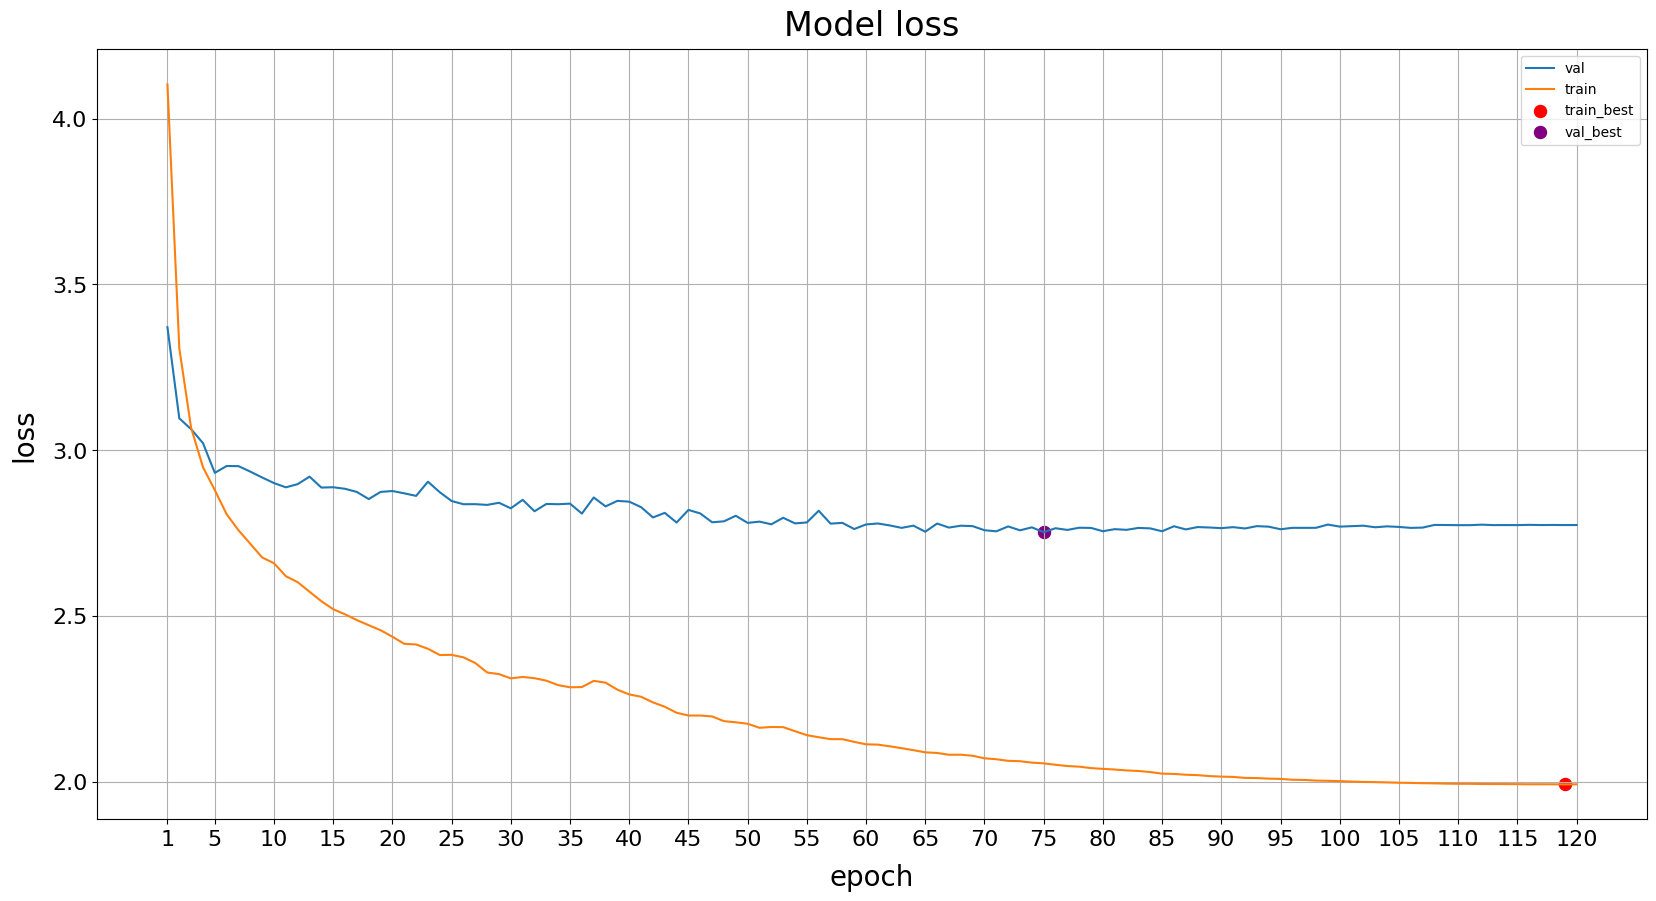

In [51]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

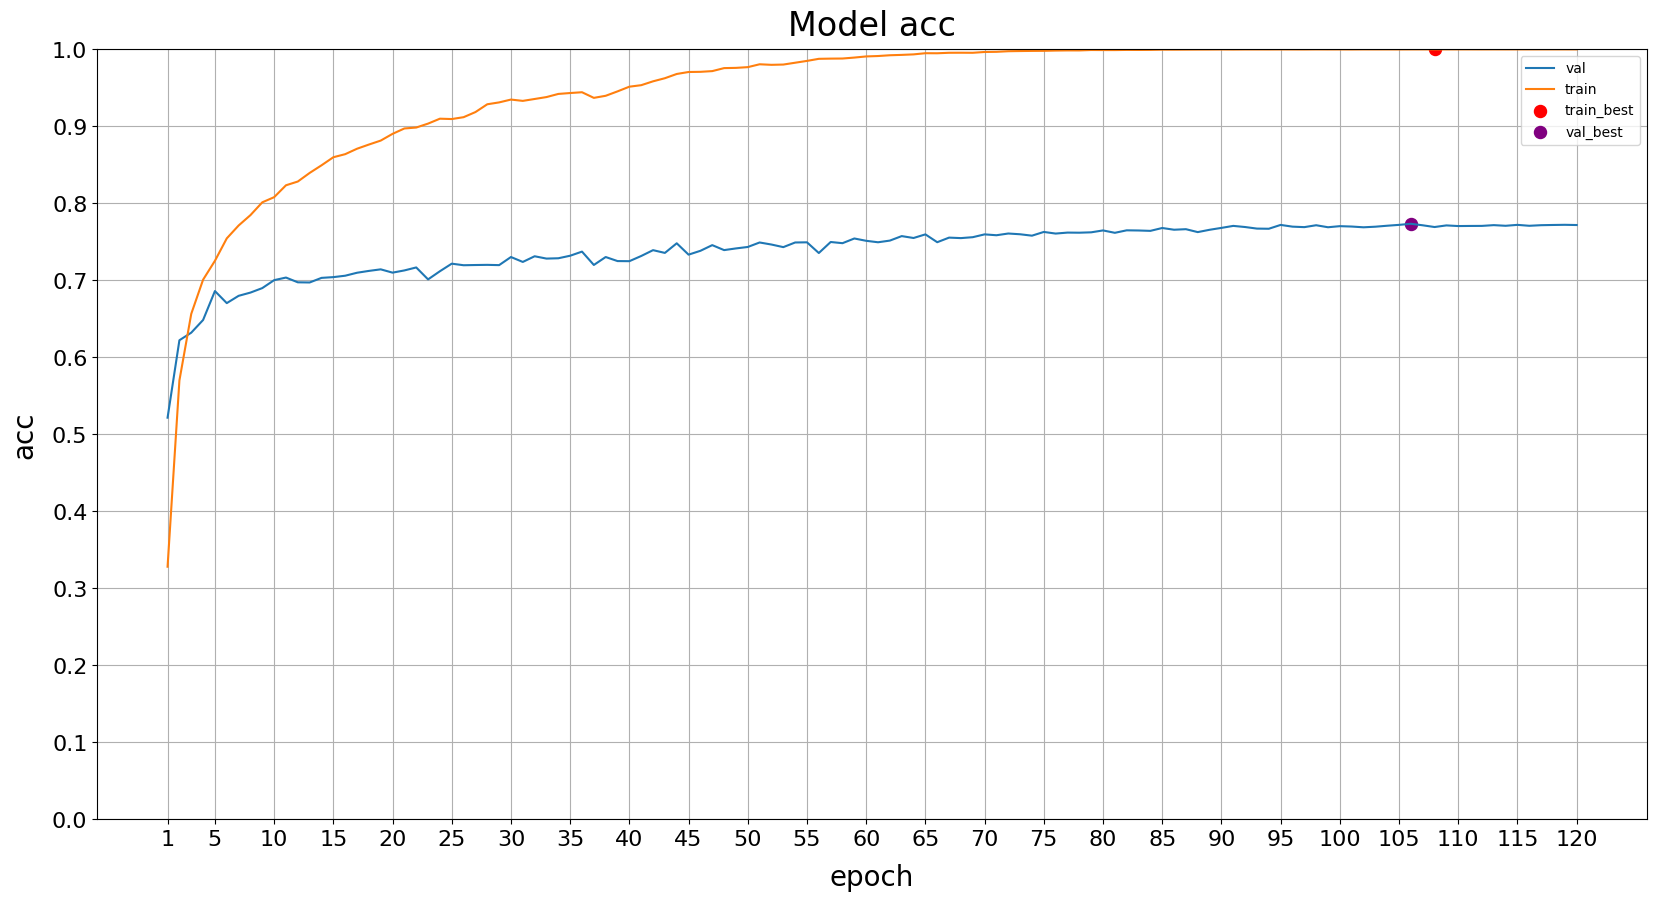

In [52]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

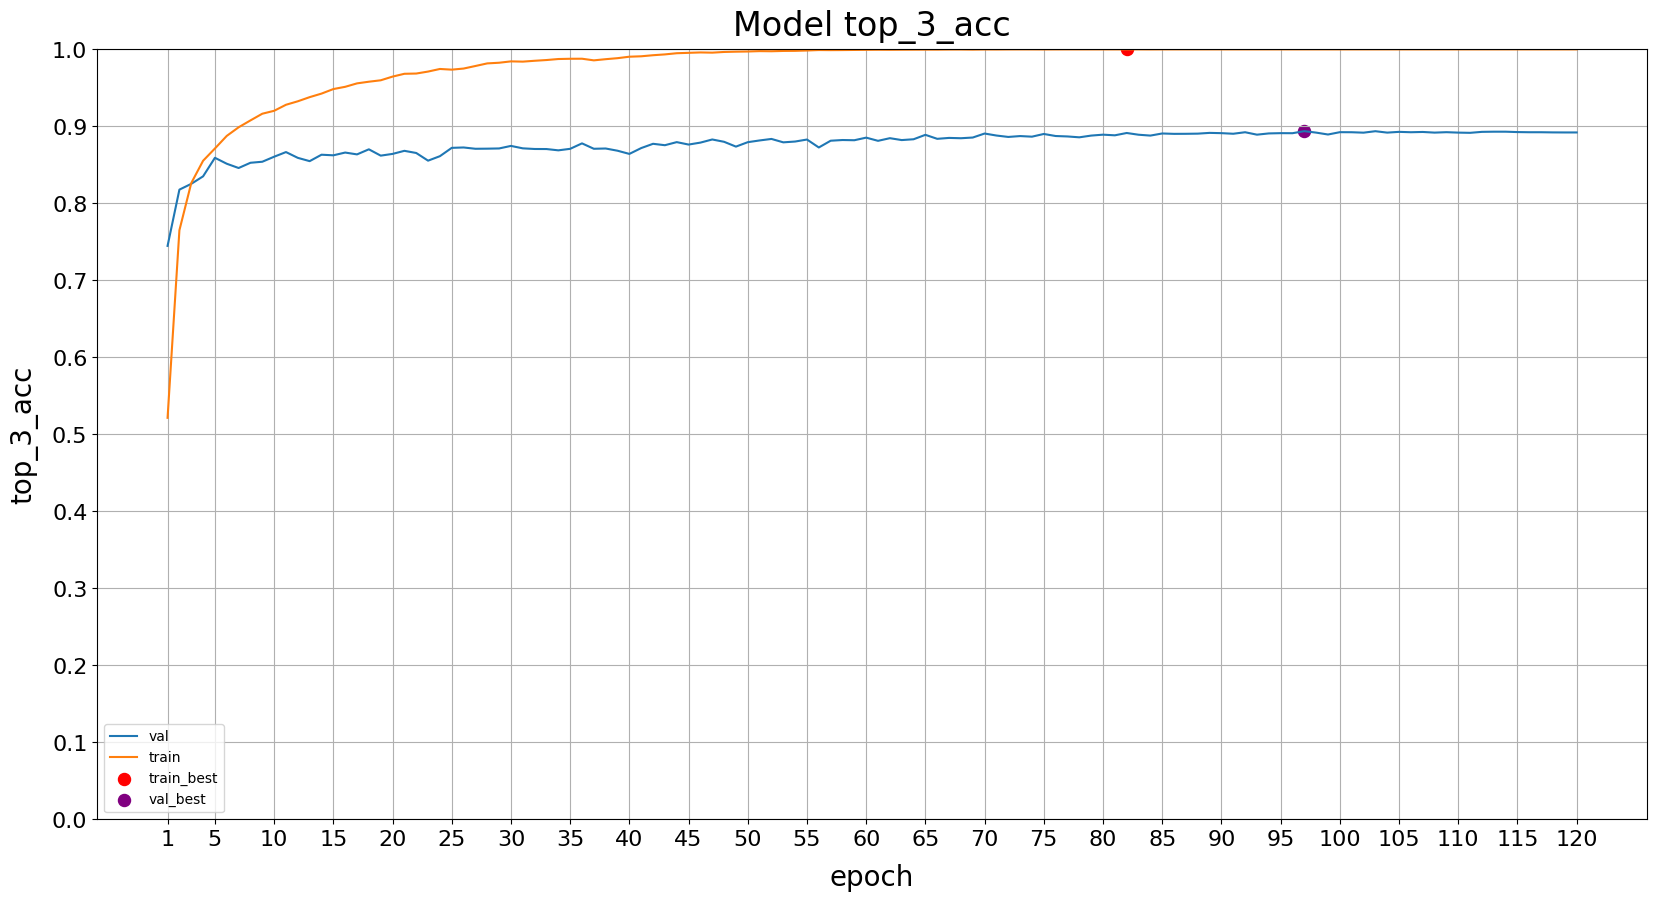

In [65]:
if TRAIN_MODEL:
    plot_history_metric('top_3_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

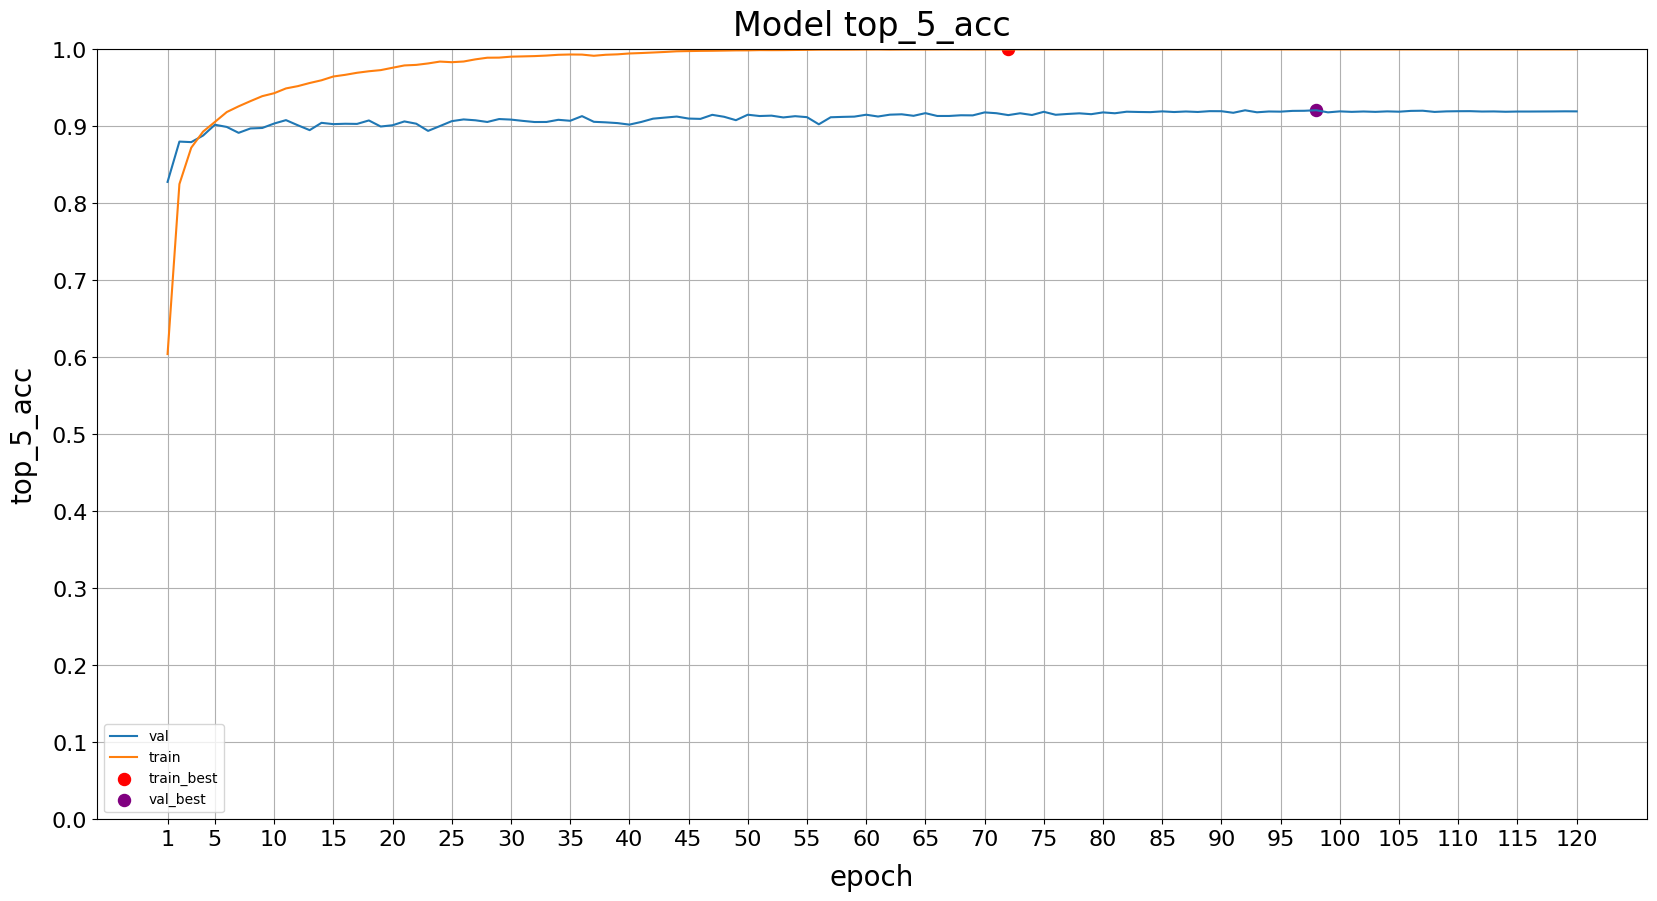

In [66]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

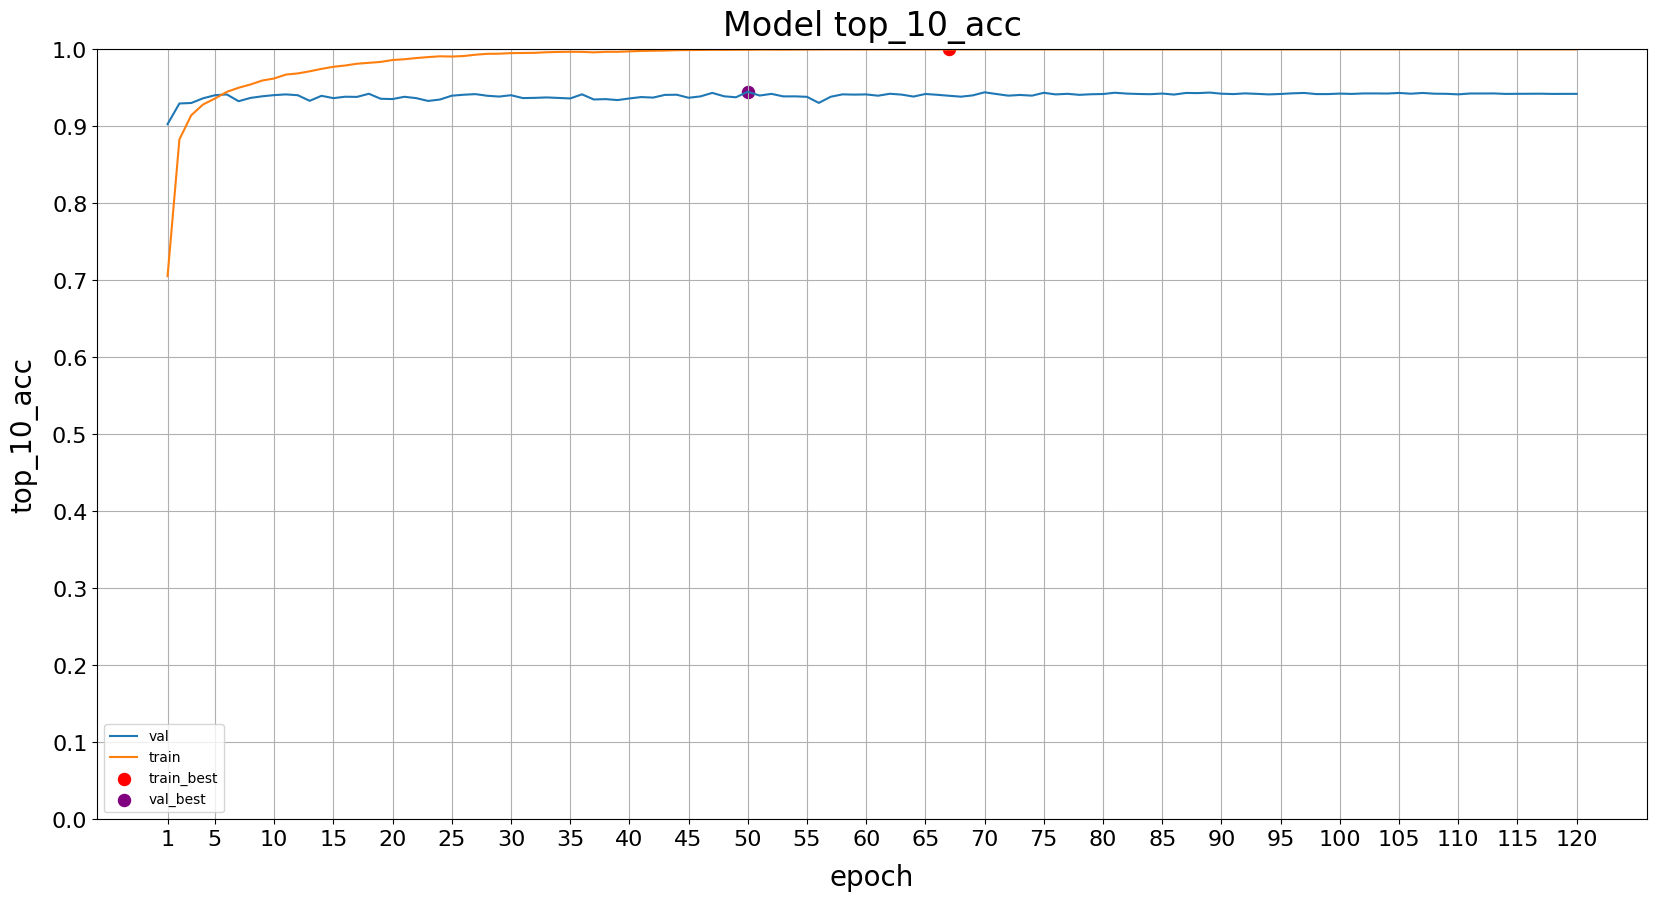

In [67]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))